In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta
import matplotlib.dates as mdates

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
lumi_directory = data_directory = "./lumi"

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [4]:
int_lumi2 = pd.read_csv(("%s/lumi_per_ls.csv" % lumi_directory),
           names=["run:fill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"])

Splitting run:fill and the start and end luminosities:

In [5]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['run:fill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Dropping useless rows from the dataframe:

In [6]:
int_lumi2.drop(int_lumi2.index[[0,1,2034,2035,2036]], inplace=True)
#print int_lumi

Converting run to integer and luminosities to float:

In [7]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 
#int_lumi2["delivered"].dtype
#int_lumi2["run"].dtype
#print int_lumi2

Converting time stamp to datetime:

In [8]:
pd.to_datetime(int_lumi2["time"])
#print int_lumi2['time']

2      2017-11-17 21:48:20
3      2017-11-17 21:48:43
4      2017-11-17 21:49:06
5      2017-11-17 21:49:30
6      2017-11-17 21:49:53
7      2017-11-17 21:50:16
8      2017-11-17 21:50:40
9      2017-11-17 21:51:03
10     2017-11-17 21:51:26
11     2017-11-17 21:51:49
12     2017-11-17 21:52:13
13     2017-11-17 21:52:36
14     2017-11-17 21:52:59
15     2017-11-17 21:53:23
16     2017-11-17 21:53:46
17     2017-11-17 21:54:09
18     2017-11-17 21:54:33
19     2017-11-17 21:54:56
20     2017-11-17 21:55:19
21     2017-11-17 21:55:43
22     2017-11-17 21:56:06
23     2017-11-17 21:56:29
24     2017-11-17 21:56:53
25     2017-11-17 21:57:16
26     2017-11-17 21:57:39
27     2017-11-17 21:58:02
28     2017-11-17 21:58:26
29     2017-11-17 21:58:49
30     2017-11-17 21:59:12
31     2017-11-17 21:59:36
               ...        
2004   2017-11-18 10:46:08
2005   2017-11-18 10:46:31
2006   2017-11-18 10:46:55
2007   2017-11-18 10:47:18
2008   2017-11-18 10:47:41
2009   2017-11-18 10:48:05
2

Creating end time column from the start time:

In [9]:
def addTimeOffSet(data):
    startdate = data.time
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

In [10]:
int_lumi2["time_end"] = int_lumi2["time"]
int_lumi2["time_end"] = int_lumi2.apply(addTimeOffSet, axis=1);

In [11]:
#print int_lumi2["time"], int_lumi2["time_end"]

Converting time stamp to datetime for plotting:

In [12]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

In [13]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    import datetime
    import matplotlib.dates as mdates
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

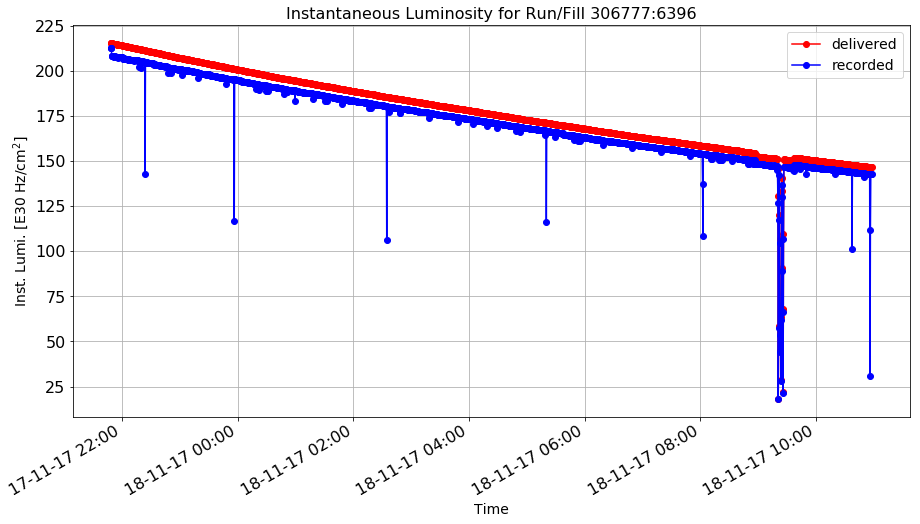

In [14]:
plot_inst_lumi(int_lumi2["time"], int_lumi2["delivered"], int_lumi2["recorded"], 
               "Instantaneous Luminosity for Run/Fill "+int_lumi2["run:fill"][2])

Reading rates from the cvs files produced by the script and saving the informations into a new pandas dataframe:

In [15]:
rates_directory = "./rates"
df_rates = pd.read_csv(("%s/dt_rates.csv" % rates_directory),
           names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"])
pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#df_rates["run"].dtype

Converting and splitting:

In [16]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [17]:
#print df_rates

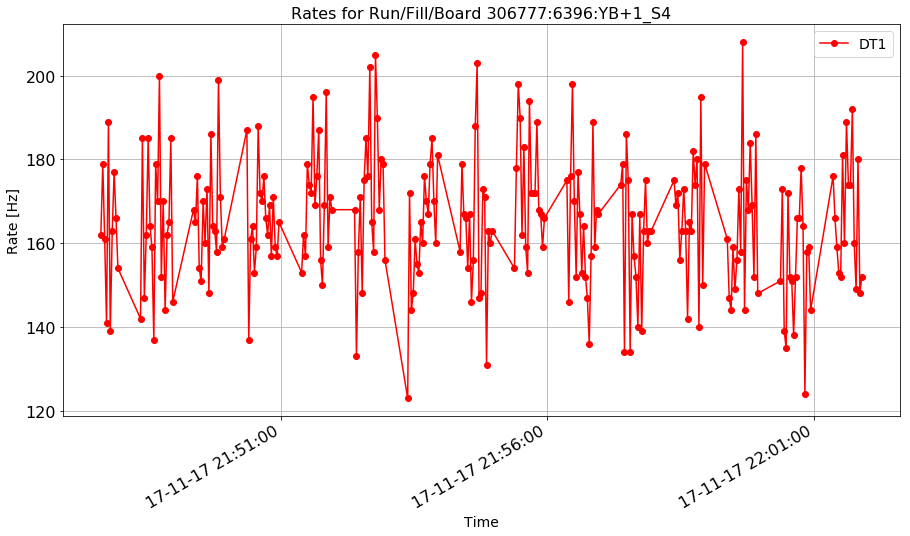

In [18]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

plot_rate_vs_time(df_rates, "time", "DT1", "YB+1_S4", "Rates for Run/Fill/Board "+int_lumi2["run:fill"][2]+":YB+1_S4")

In [19]:
df_rates["ls"] = -1
df_rates["start"] = -1
df_rates["end"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates["errorRPC1"] = -1.0
df_rates["errorRPC2"] = -1.0
df_rates["errorRPC3"] = -1.0
df_rates["errorRPC4"] = -1.0
df_rates["errorDT1"] = -1.0
df_rates["errorDT2"] = -1.0
df_rates["errorDT3"] = -1.0
df_rates["errorDT4"] = -1.0
df_rates["errorDT5"] = -1.0
#print df_rates["ls"]

Associating a LS and an instantaneous luminosity to each rate:

In [20]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        result = (start <= x <= end)
        return result
    else:
        return start <= x or x <= end

def assignLS(df1, df2):
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        rate_time = pd.to_datetime(row1["time"])
        time0 = df2["time"].iloc[0]
        if rate_time <= time0:
            continue;
        for index2, row2 in df2.iterrows():
            run2 = row2["run"]
            if (run1 != run2):
                continue;
            time1 = pd.to_datetime(row2["time"])
            time2 = pd.to_datetime(row2["time_end"])
            if time_in_range(time1, time2, rate_time):
                df1.set_value(index1, 'ls', row2["ls_start"])
                df1.set_value(index1, 'start', row2["time"])
                df1.set_value(index1, 'end', row2["time_end"])
                df1.set_value(index1, 'lumi', row2["delivered"])
                break
assignLS(df_rates, int_lumi2)

In [21]:
#print df_rates[df_rates["ls"] >= 0]

In [22]:
df_rates = df_rates[df_rates.ls > 0]
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
#print df_rates

Averaging the rates associated to the same LS:

In [23]:
df_chamber = df_rates["board"]
df_chamber = df_chamber[df_chamber.duplicated() == False]
#print df_chamber

algos = ["RPC1", "RPC2", "RPC3", "RPC4","DT1", "DT2", "DT3", "DT4", "DT5"]
resultAverage = []
for x in algos:
    #print x
    for y in df_chamber:
        #print y
        rate = df_rates[df_rates["board"] == y]
        rule = rate.duplicated(subset=["run", "wheel", "sector", "ls", "lumi", "start", "end"])
        count = (rule == False).sum()
        #print count
        for i in range(count):
            #print rate[rate["ls"] == i]
            rate2 = rate[rate["ls"] == (i+1)]
            #print rate2[x]
            std = round(rate2[x].std(), 1)
            mean = round(rate2[x].mean(), 1)
            #print mean, std
            indexes = rate2[x].index
            #print i+1, indexes
            resultAverage.append([x, indexes, mean, std])
            #print resultAverage

In [24]:
#print df_rates[df_rates["board"] == "YB0_S2"]["RPC1"]
#print df_rates[df_rates["board"] == "YB0_S1"]["RPC1"]

Removing the duplicates:

In [25]:
rule = df_rates.duplicated(subset=["run", "wheel", "sector", "ls", "lumi"])
print "Duplicates:", rule.sum()
df_rates = df_rates[rule == False]

Duplicates: 12121


Assigning the average rates previously calculated to the remaining rows:

In [26]:
for obj in resultAverage:
    #print obj[0], obj[1], obj[2], obj[3]
    for index, row in df_rates.iterrows():
        if index in obj[1]:
            #df_rates.set_value(index, obj[0], obj[2])
            df_rates.loc[index, obj[0]] = obj[2]
            df_rates.loc[index, "error"+obj[0]] = obj[3]

In [27]:
for index, row in df_rates.iterrows():
    if row["board"] == "YB0_S1":
        print index, row["run"], row["board"], row["ls"], row["lumi"], row["RPC1"], row["errorRPC1"]

600 306777 YB0_S1 1 215.711 1778.3 89.3
1200 306777 YB0_S1 2 215.755 1938.5 90.1
1680 306777 YB0_S1 3 215.599 2027.5 65.5
1920 306777 YB0_S1 4 215.552 1854.5 140.9
2610 306777 YB0_S1 5 215.477 1786.5 43.1
2700 306777 YB0_S1 6 215.449 1973.0 28.0
3240 306777 YB0_S1 7 215.395 2004.7 42.2
3780 306777 YB0_S1 8 215.292 1936.0 49.5
3900 306777 YB0_S1 9 215.336 1770.7 218.0
4500 306777 YB0_S1 10 215.181 1721.4 45.1
4800 306777 YB0_S1 11 215.192 1997.1 56.8
5250 306777 YB0_S1 12 215.237 2048.9 232.4
5880 306777 YB0_S1 14 214.96 2448.5 588.4
6480 306777 YB0_S1 15 215.006 1917.8 173.0
6840 306777 YB0_S1 16 214.993 2256.0 343.0
7200 306777 YB0_S1 17 214.969 2043.7 81.0
7890 306777 YB0_S1 18 214.908 2143.0 nan
7920 306777 YB0_S1 19 214.78 2007.9 151.1
8520 306777 YB0_S1 20 214.851 2194.9 38.0
8994 306777 YB0_S1 21 214.801 2073.5 41.2
9180 306777 YB0_S1 22 214.678 2141.8 246.3
9840 306777 YB0_S1 23 214.734 2127.3 42.5
10020 306777 YB0_S1 24 214.567 2062.0 103.3
10530 306777 YB0_S1 25 214.688 1877.2

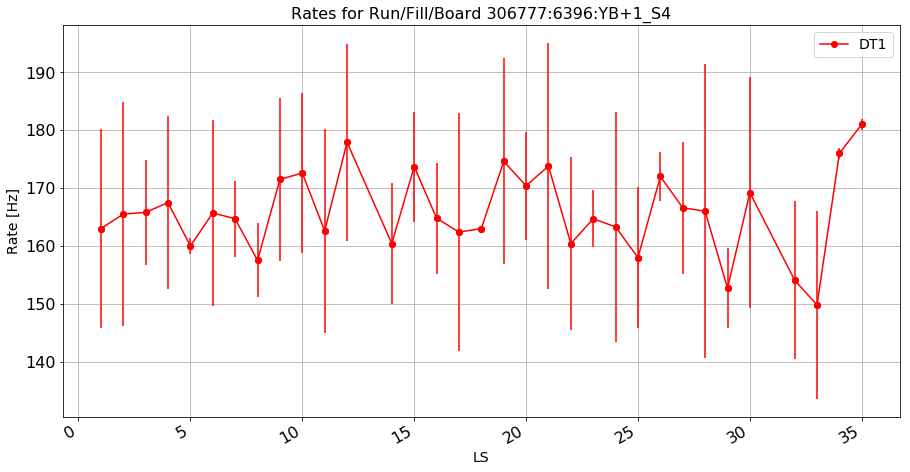

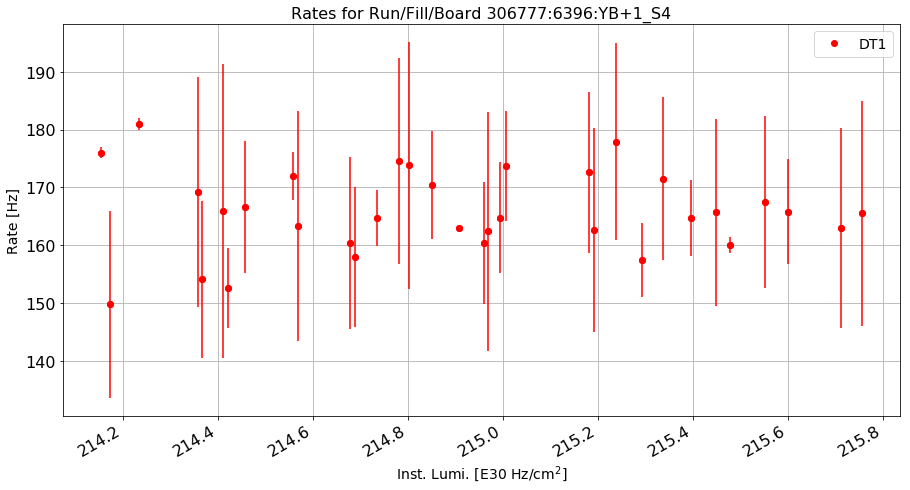

In [28]:
def plot_rate_vs_ls(df, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

plot_rate_vs_ls(df_rates, "ls", "DT1", "YB+1_S4", 0, "errorDT1", "LS", "Rate [Hz]", "Rates for Run/Fill/Board "
                +int_lumi2["run:fill"][2]+":YB+1_S4", "ro-")
plot_rate_vs_ls(df_rates, "lumi", "DT1", "YB+1_S4", 0, "errorDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", "Rate [Hz]", 
                "Rates for Run/Fill/Board "+int_lumi2["run:fill"][2]+":YB+1_S4", "ro")

In [29]:
df_rates_new = pd.DataFrame(columns=["content","score"])
for index, row in df_rates.iterrows():
    for j in algos:
        #print j
        system = 0
        station = 0
        if (j.find("RPC") != -1):
            system = 1
        else:
            system = 2
        num = j.replace("RPC", "")
        num = num.replace("DT", "")
        station = int(num)
        array = np.array([system, row["wheel"], row["sector"], station, row[j], row["error"+j], row["lumi"]])
        #print array
        df_rates_new = df_rates_new.append({"content":array, "score":row["score"]}, ignore_index=True)

In [30]:
#print df_rates_new

Creating train and test samples:

In [31]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)

anomalies = df_rates_new[df_rates_new.score == 1]
normalies = df_rates_new[df_rates_new.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

print("Number of anomalies in the train set: %s" % len(anomalies_test))
print("Number of normal in the train set: %s" % len(normalies_test))

0 faults and 17820 good samples. In total: 17820.
Number of anomalies in the train set: 0
Number of normal in the train set: 3564


In [32]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])

        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="CNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('Fall-out (TNR)')
    plt.show();

In [33]:
sess = tf.Session()
K.set_session(sess)

In [34]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0])
    return np.asarray([0, 1])

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content.values)).reshape(-1, 7),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content.values)).reshape(-1, 7),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content.values)).reshape(-1, 7))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

Defining NN structure:

In [35]:
def neural_network():
    model = Sequential()
    model.add(Reshape((7, 1), input_shape=(7,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(16, activation='relu', name="dense_ann"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

In [36]:
ann = neural_network()
print("Neural Network Architecture:")
ann.summary()

Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 7, 1)              0         
_________________________________________________________________
flatten_ann (Flatten)        (None, 7)                 0         
_________________________________________________________________
dense_ann (Dense)            (None, 16)                128       
_________________________________________________________________
output_ann (Dense)           (None, 2)                 34        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


Training the NN:

In [37]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [38]:
history_ann = train_nn(ann,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann",
                       validation_data=(val_x, val_y),
                       class_weight=None)

Epoch 00032: early stopping


Making an inference using the model and the test sample:

In [39]:
ann_model = load_model("./model_keras/ann.h5")
layers_test["ann_score"] = ann_model.predict(np.array(test_x))[:, 1]

In [40]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
#specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score"], 0.5)

In [41]:
#get_roc_curve(layers_test,
#               ("Neural Network", "ann_score"),
#              (specificity_ann, sensitivity_ann))